In [1]:
import pandas as pd
import numpy as np
from networkx.drawing.layout import bipartite_layout
import nltk
import string
import matplotlib.pyplot as plt
import networkx as nx
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
tweets_df = pd.read_excel('twitter_dataset.xlsx')
tweets_df

,Tweet_ID,Username,Text,Retweets,Likes,Timestamp
0,1,pmora,Party least receive say or single. Prevent pre...,2,25,2023-01-30 11:00:00
1,2,dylancooley,Hotel still Congress may member staff. Media d...,35,29,2023-01-02 22:45:00
2,3,stephanie84,Nice be her debate industry that year. Film wh...,51,25,2023-01-18 11:25:00
3,4,barbarabell,Laugh explain situation career occur serious. ...,37,18,2023-04-10 22:06:00
4,5,larry58,Involve sense former often approach government...,27,80,2023-01-24 07:12:00
...,...,...,...,...,...,...
9995,9996,vnelson,Agree reflect military box ability ever hold. ...,81,86,2023-01-15 11:46:00
9996,9997,ricky87,Born which push still. Degree sometimes contro...,73,100,2023-05-06 00:46:00
9997,9998,amylewis,You day agent likely region. Teacher data mess...,10,62,2023-02-27 14:55:00
9998,9999,scott27,Guess without successful save. Particular natu...,21,60,2023-01-09 16:09:00


In [4]:
following_df = pd.read_excel('users_following.xlsx')
following_df

,Username,Following
0,pmora,rogerhernandez; sara68; lwatkins; eclark; robe...
1,dylancooley,warrenemily; marvinwilliams; nathaniellee; lau...
2,stephanie84,martinezkathryn; nicholasreyes; jonathangardne...
3,barbarabell,elizabethnichols; whitechristopher; harveystep...
4,larry58,chavezjames; josephbrown; turneredgar; gallagh...
...,...,...
1235,laurencarrillo,maxjohnston; chelseaaustin; donovanchristine; ...
1236,pearsonchristopher,lisa00; montoyasheila; justin91; jenniferharri...
1237,jeffreyturner,knightcynthia; thomasdorothy; turneredgar; mar...
1238,weavergrace,lgordon; smithadriana; nrodriguez; gcoleman; s...


In [5]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

tweets_df['processed_text'] = tweets_df['Text'].apply(preprocess_text)
tweets_df

,Tweet_ID,Username,Text,Retweets,Likes,Timestamp,processed_text
0,1,pmora,Party least receive say or single. Prevent pre...,2,25,2023-01-30 11:00:00,"[party, least, receive, say, single, prevent, ..."
1,2,dylancooley,Hotel still Congress may member staff. Media d...,35,29,2023-01-02 22:45:00,"[hotel, still, congress, may, member, staff, m..."
2,3,stephanie84,Nice be her debate industry that year. Film wh...,51,25,2023-01-18 11:25:00,"[nice, debate, industry, year, film, generatio..."
3,4,barbarabell,Laugh explain situation career occur serious. ...,37,18,2023-04-10 22:06:00,"[laugh, explain, situation, career, occur, ser..."
4,5,larry58,Involve sense former often approach government...,27,80,2023-01-24 07:12:00,"[involve, sense, former, often, approach, gove..."
...,...,...,...,...,...,...,...
9995,9996,vnelson,Agree reflect military box ability ever hold. ...,81,86,2023-01-15 11:46:00,"[agree, reflect, military, box, ability, ever,..."
9996,9997,ricky87,Born which push still. Degree sometimes contro...,73,100,2023-05-06 00:46:00,"[born, push, still, degree, sometimes, control..."
9997,9998,amylewis,You day agent likely region. Teacher data mess...,10,62,2023-02-27 14:55:00,"[day, agent, likely, region, teacher, data, me..."
9998,9999,scott27,Guess without successful save. Particular natu...,21,60,2023-01-09 16:09:00,"[guess, without, successful, save, particular,..."


In [6]:
def hits_algorithm(graph, tol=1e-6):
    hub_scores = {node: 1 for node in graph.nodes}
    authority_scores = {node: 1 for node in graph.nodes}

    while True:
        new_hub_scores = {}
        new_authority_scores = {}

        # Update authority scores
        for node in graph.nodes:
            new_authority_scores[node] = sum(hub_scores[neighbor] for neighbor in graph.neighbors(node))

        # Update hub scores
        for node in graph.nodes:
            new_hub_scores[node] = sum(authority_scores[neighbor] for neighbor in graph.neighbors(node))

        # Normalize scores
        normalization_factor = max(max(new_hub_scores.values()), max(new_authority_scores.values()))
        new_hub_scores = {node: score / normalization_factor for node, score in new_hub_scores.items()}
        new_authority_scores = {node: score / normalization_factor for node, score in new_authority_scores.items()}

        # Check for convergence
        hub_convergence = all(abs(new_hub_scores[node] - hub_scores[node]) < tol for node in graph.nodes)
        authority_convergence = all(abs(new_authority_scores[node] - authority_scores[node]) < tol for node in graph.nodes)

        if hub_convergence and authority_convergence:
            break

        hub_scores, authority_scores = new_hub_scores, new_authority_scores

    return hub_scores, authority_scores


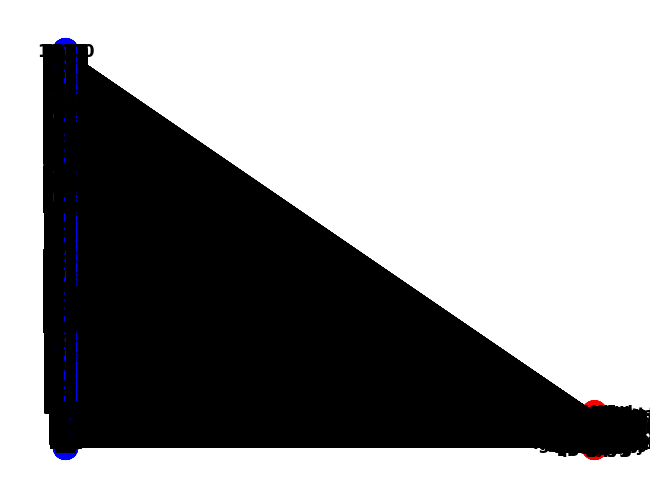

In [11]:
G_bipartite = nx.Graph()

# Add nodes for tweets and words
tweet_nodes = list(tweets_df['Tweet_ID'])
word_nodes = set()

G_bipartite.add_nodes_from(tweet_nodes, bipartite=0, node_type='tweet')  # Set bipartite attribute for tweets

# Tokenize and process each tweet
stop_words = set(stopwords.words('english'))
translator = str.maketrans('', '', string.punctuation)

for index, tweet in tweets_df.iterrows():
    Tweet_ID = tweet['Tweet_ID']
    tweet_text = tweet['Text']

    words = [word.lower() for word in word_tokenize(tweet_text) if word.isalpha() and word.lower() not in stop_words]
    word_nodes.update(words)  # Update word nodes

    # Add edges connecting tweets to words
    for word in words:
        G_bipartite.add_edge(Tweet_ID, word)

# Add nodes for words
G_bipartite.add_nodes_from(word_nodes, bipartite=1, node_type='word')  # Set bipartite attribute for words

# Optional: Visualize the bipartite graph
import matplotlib.pyplot as plt

pos = {node: (0, i) for i, node in enumerate(tweet_nodes)}
pos.update({node: (1, i) for i, node in enumerate(word_nodes)})

nx.draw(G_bipartite, pos=pos, with_labels=True, font_weight='bold', node_color=['blue' if G_bipartite.nodes[node]['node_type'] == 'tweet' else 'red' for node in G_bipartite.nodes])
plt.show()

<ipython-input-12-360645ec6a91>:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  subset_word_nodes = random.sample(word_nodes, min(10, len(word_nodes)))


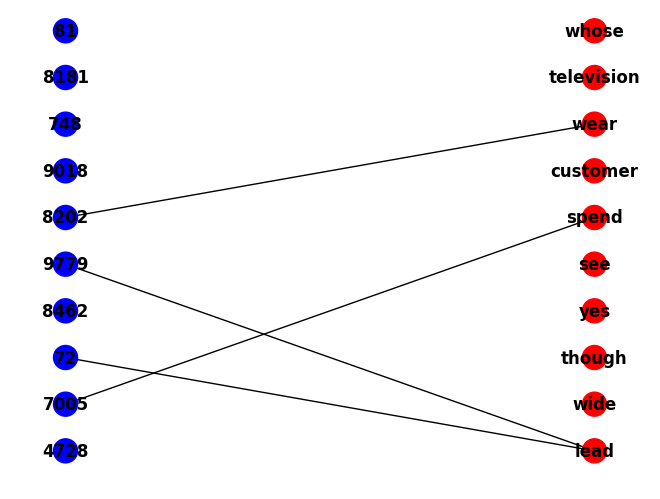

In [12]:
import random

# Select a random subset of tweets and words for visualization
subset_tweet_nodes = random.sample(tweet_nodes, min(10, len(tweet_nodes)))
subset_word_nodes = random.sample(word_nodes, min(10, len(word_nodes)))

# Create a subgraph containing only the selected nodes and their edges
subgraph_nodes = subset_tweet_nodes + subset_word_nodes
subgraph = G_bipartite.subgraph(subgraph_nodes)

# Visualize the subgraph
pos = nx.bipartite_layout(subgraph, subset_tweet_nodes)
nx.draw(subgraph, pos=pos, with_labels=True, font_weight='bold', node_color=['blue' if subgraph.nodes[node]['node_type'] == 'tweet' else 'red' for node in subgraph.nodes])
plt.show()


In [22]:
#Use hits_algorithm function on the bipartite graph
hub_scores, authority_scores = hits_algorithm(G_bipartite)

# Now, hub_scores and authority_scores contain the final hub and authority scores for each tweet in the graph.
print("Hub Scores:", hub_scores)
print("Authority Scores:", authority_scores)

Hub Scores: {1: 0.06569343065693431, 2: 0.06082725060827251, 3: 0.0681265206812652, 4: 0.06326034063260341, 5: 0.0827250608272506, 6: 0.0827250608272506, 7: 0.0851581508515815, 8: 0.06569343065693431, 9: 0.06569343065693431, 10: 0.07542579075425791, 11: 0.0535279805352798, 12: 0.06326034063260341, 13: 0.06082725060827251, 14: 0.0681265206812652, 15: 0.06326034063260341, 16: 0.058394160583941604, 17: 0.072992700729927, 18: 0.07542579075425791, 19: 0.08029197080291971, 20: 0.072992700729927, 21: 0.07542579075425791, 22: 0.06082725060827251, 23: 0.07785888077858881, 24: 0.06082725060827251, 25: 0.08029197080291971, 26: 0.05596107055961071, 27: 0.07785888077858881, 28: 0.0413625304136253, 29: 0.051094890510948905, 30: 0.09732360097323602, 31: 0.0705596107055961, 32: 0.0827250608272506, 33: 0.08759124087591241, 34: 0.09002433090024331, 35: 0.0705596107055961, 36: 0.07542579075425791, 37: 0.0705596107055961, 38: 0.08029197080291971, 39: 0.0535279805352798, 40: 0.072992700729927, 41: 0.043795

In [28]:
# Reflect Authority Scores to Users
# Assign authority scores to users
user_authority_scores = {user: 0.0 for user in set(tweets_df['Username'])}  # Initialize authority scores for users

# Iterate over tweets and update authority scores for users
for Tweet_ID, _ in G_bipartite.edges:
    Username = tweets_df.loc[tweets_df['Tweet_ID'] == Tweet_ID, 'Username'].iloc[0]
    user_authority_scores[Username] += authority_scores[Tweet_ID]

# Page Rank Algorithm for User Ranking
user_graph = nx.DiGraph()

# Add nodes for users
user_nodes = list(set(tweets_df['Username']))
user_graph.add_nodes_from(user_nodes)

# Iterate over each row in the DataFrame
for index, row in following_df.iterrows():
    following_list = row['Following'].split('; ')

    # Add edges connecting users based on following relationships
    for i in range(len(following_list) - 1):
        user_graph.add_edge(following_list[i], following_list[i + 1])

# Use PageRank algorithm with initial values from HITS
pagerank_scores = nx.pagerank(user_graph, personalization=user_authority_scores)

# Now, pagerank_scores contains the final importance scores for users based on the PageRank algorithm.
print("PageRank Scores:", pagerank_scores)


PageRank Scores: {'jwoods': 0.0005773010553450915, 'dcurtis': 0.0002644642827666834, 'taylorbenjamin': 0.0008912700921178003, 'bperez': 0.0008659669850481117, 'qcross': 0.0007471469598887663, 'davidevans': 0.0005798826299600775, 'sullivanheather': 0.0012550750870025846, 'gilbertstephen': 0.000673965922964474, 'andrea59': 0.0006381810213961121, 'emedina': 0.0009190770263386991, 'steven03': 0.0006268591648236396, 'jonathanhunt': 0.0009979194210155548, 'simonshawn': 0.0005505050044974423, 'richardperry': 0.0010754513406242123, 'gregorydixon': 0.0007993053982783408, 'davidalvarez': 0.0023783223049121363, 'aliciadickerson': 0.00044720278024313795, 'jim78': 0.0010583059126847434, 'xkelley': 0.0006161039330439257, 'dmorris': 0.0008777268724551319, 'pwright': 0.0006560682731440416, 'sherry41': 0.00102202130912449, 'bergerjohn': 0.0005014870733788314, 'johndean': 0.002222342128279129, 'mooneykevin': 0.0006943879673336273, 'rmartinez': 0.0007203345590875443, 'ashley07': 0.0012013387119441884, 'q

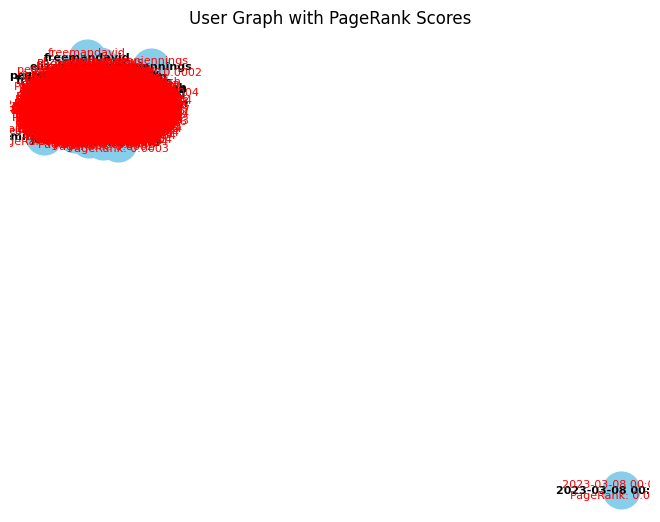

In [29]:
# Visualize the graph
pos = nx.spring_layout(user_graph)  # You can choose a different layout if needed
nx.draw(user_graph, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=8, font_color='black', font_weight='bold', arrowsize=10)

# Annotate nodes with PageRank scores
pagerank_labels = {user: f"{user}\nPageRank: {pagerank_scores[user]:.4f}" for user in user_nodes}
nx.draw_networkx_labels(user_graph, pos, labels=pagerank_labels, font_size=8, font_color='red')

plt.title("User Graph with PageRank Scores")
plt.show()

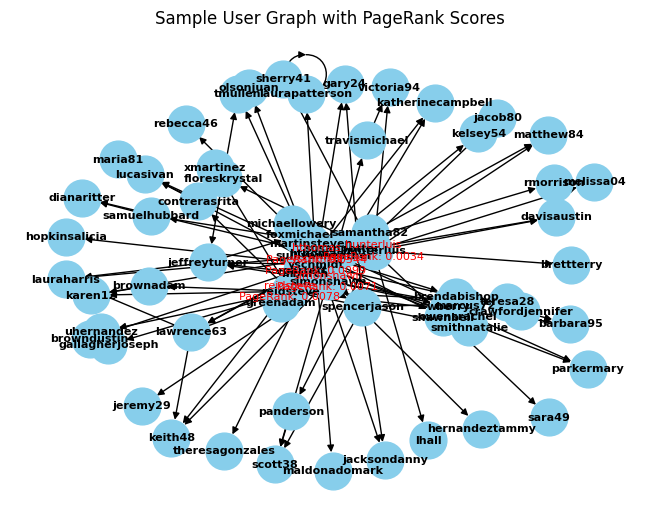

In [30]:
# Sample a subset of users and their followers for visualization
sample_users = random.sample(list(user_nodes), min(5, len(user_nodes)))  # Adjust the sample size as needed
sample_followers = [(u, v) for u, v in user_graph.edges() if u in sample_users]

# Create a subgraph with the sampled nodes and edges
sample_user_graph = user_graph.subgraph(sample_users + [follower for _, follower in sample_followers])

# Use PageRank algorithm with initial values from HITS on the sample
sample_pagerank_scores = nx.pagerank(sample_user_graph, personalization=user_authority_scores)

# Visualize the sample graph
pos = nx.spring_layout(sample_user_graph)
nx.draw(sample_user_graph, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=8, font_color='black', font_weight='bold', arrowsize=10)

# Annotate nodes with PageRank scores
pagerank_labels = {user: f"{user}\nPageRank: {sample_pagerank_scores[user]:.4f}" for user in sample_users}
nx.draw_networkx_labels(sample_user_graph, pos, labels=pagerank_labels, font_size=8, font_color='red')

plt.title("Sample User Graph with PageRank Scores")
plt.show()